<a href="https://colab.research.google.com/github/rashida048/ApacheSpark-BigDataAnalytics/blob/main/Calculating_parameters_with_formulas_linear_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 61 kB/s 
     |████████████████████████████████| 198 kB 52.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=9b7001d5dcd36308de1302f504148310ef1d0949bbe396af2183cdf1b9a3b0d8
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [ ]:
rd = sc.textFile("taxi-data-sorted-small.csv.bz2")

In [ ]:
rd.take(3)

['07290D3599E7A0D62097A346EFCC1FB5,E7750A37CAB07D0DFF0AF7E3573AC141,2013-01-01 00:00:00,2013-01-01 00:02:00,120,0.44,-73.956528,40.716976,-73.962440,40.715008,CSH,3.50,0.50,0.50,0.00,0.00,4.50',
 '22D70BF00EEB0ADC83BA8177BB861991,3FF2709163DE7036FCAA4E5A3324E4BF,2013-01-01 00:02:00,2013-01-01 00:02:00,0,0.00,0.000000,0.000000,0.000000,0.000000,CSH,27.00,0.00,0.50,0.00,0.00,27.50',
 '0EC22AAF491A8BD91F279350C2B010FD,778C92B26AE78A9EBDF96B49C67E4007,2013-01-01 00:01:00,2013-01-01 00:03:00,120,0.71,-73.973145,40.752827,-73.965897,40.760445,CSH,4.00,0.50,0.50,0.00,0.00,5.00']

In [ ]:
words = rd.map(lambda x: x.split(','))

In [ ]:
words.count()

88914

In [ ]:
def isfloat(value):
    try:
        float(value)
        return True
    except:
        return False

In [ ]:
def correctRows(p):
    if(len(p)==17):
        if(isfloat(p[5]) and isfloat(p[11])):
            if(float(p[5]) !=0 and float(p[11]) !=0):
                return p

In [ ]:
wordsCorr = words.filter(lambda x: correctRows(x))

In [ ]:
wordsCorr.count()

88131

In [ ]:
dist_fair = wordsCorr.map(lambda x: (float(x[5]), float(x[16])))

In [ ]:
dist_fair.take(3)

[(0.44, 4.5), (0.71, 5.0), (0.48, 5.0)]

In [ ]:
xsum_ysum = dist_fair.reduce(lambda x, y: ((x[0] + y[0]), (x[1] + y[1])))

In [ ]:
nxy = dist_fair.map(lambda x: x[0] * x[1]).reduce(lambda x, y: x+y)

In [ ]:
nxy

155936189.45189738

In [ ]:
n_x_sqrd = dist_fair.map(lambda x: x[0]**2).reduce(lambda x, y: x+y)

In [ ]:
n_x_sqrd

40345270.133203365

In [ ]:
n = dist_fair.count()

In [ ]:
m = (nxy*n - xsum_ysum[0]*xsum_ysum[1])/(n_x_sqrd*n - xsum_ysum[0]**2)

In [ ]:
m

3.1695880607501863

In [ ]:
b = (n_x_sqrd*n - xsum_ysum[0]*nxy) / (n*n_x_sqrd - (xsum_ysum[0])**2)

In [ ]:
b

-17.50932836704813

Task - 2

In [ ]:
m = 0.1
b = 0.1
lr = 0.0000001
iter = 50

precision = 0.01
n = 5000
const = -2/n

In [ ]:
const

-0.0004

In [ ]:
dist_fair.map(lambda x: (x[1] - (m*x[0] + b)**2)).reduce(lambda x, y: x+y)

-8.267038260208586e+129

In [ ]:
dist_fair.take(3)

[(0.44, 4.5), (0.71, 5.0), (0.48, 5.0)]

In [ ]:
def y_pred(x, m, b):
  return (x[1] - (m*x[0] + b))

In [ ]:
sample = dist_fair.sample(False, 5000)

In [ ]:
init_cost = sample.map(lambda x: (x[1] - (m*x[0] + b)**2)).reduce(lambda x, y: x+y)
cost_list = [init_cost]
m_list = [0.1]
b_list = [0.1]
for i in range(4):
  #l = dist_fair.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  del_m = (sample.map(lambda x: x[0] * y_pred(x, m, b)).reduce(lambda x, y: x+y))
  m_cost = del_m*const
  del_b = (sample.map(lambda x: y_pred(x, m, b)).reduce(lambda x, y: x+y))
  b_cost = del_b*const
  m -= m_cost
  print(m)
  b -= del_b
  l = sample.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  m_list.append(m)
  b_list.append(b)
  cost_list.append(l)
total_list = (m_list, b_list, cost_list)

5.220511110987752e+27
4.1463254961886867e+33
3.2931670419565763e+39
2.6155566359113865e+45


In [ ]:
m = 0.1
b = 0.1
lr = 0.0000001
iter = 50

precision = 0.01
n = 5000
const = -2/n

for i in range(4):
  #l = dist_fair.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  del_m = (sample.map(lambda x: x[0] * (x[1] - (m*x[0] + b))).reduce(lambda x, y: x+y))
  m_cost = del_m*const
  del_b = (sample.map(lambda x: x[1] - (m*x[0] + b)).reduce(lambda x, y: x+y))
  b_cost = del_b*const*lr
  m -= m_cost*lr
  #print(m)
  b -= del_b*lr
  l = sample.map(lambda x: (x[1] - (m*x[0] + b))**2).reduce(lambda x, y: x+y)
  print(l)
  m_list.append(m)
  b_list.append(b)
  cost_list.append(l)
total_list1 = (m_list, b_list, cost_list)

284271292.61326194
313228611.598402
346981573.5382645
386322193.84333074


In [ ]:
total_list[1]

[0.1,
 -11004807.721000267,
 -8710276639456.543,
 -6.918153344075773e+18,
 -5.49465603830104e+24]

In [ ]:
m = 0.1
b = 0.1
lr = 0.0000001
iter = 50

precision = 0.01
n = 5000
const = -2/n

for i in range(4):
  #l = dist_fair.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  del_m = (sample.map(lambda x: x[0] * (x[1] - (m*x[0] + b))).reduce(lambda x, y: x+y))
  m_cost = del_m*const
  del_b = (sample.map(lambda x: x[1] - (m*x[0] + b)).reduce(lambda x, y: x+y))
  b_cost = del_b*const*lr
  m += m_cost*lr
  #print(m)
  b += del_b*lr
  l = sample.map(lambda x: (x[1] - (m*x[0] + b))**2).reduce(lambda x, y: x+y)
  print(l)
  m_list.append(m)
  b_list.append(b)
  cost_list.append(l)
total_list = (m_list, b_list, cost_list)

236492182.98441684
217065593.68204433
200614528.64764398
186685114.0097357


In [ ]:
total_list[2][-4:]

[236492182.98441684, 217065593.68204433, 200614528.64764398, 186685114.0097357]

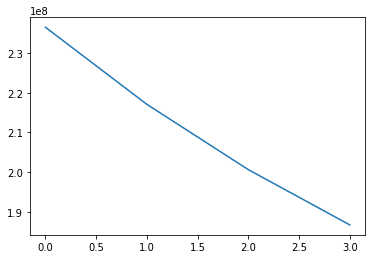

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(4)), total_list[2][-4:])
plt.show()

In [ ]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

"Task-2 Final

In [ ]:
m = 0.1
b = 0.1
lr = 0.0000001
iter = 50

precision = 0.01
n = 5000
const = -2/n

init_cost = sample.map(lambda x: (x[1] - (m*x[0] + b)**2)).reduce(lambda x, y: x+y)
cost_list = [init_cost]
m_list = [0.1]
b_list = [0.1]

for i in range(4):
  #l = dist_fair.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  del_m = (sample.map(lambda x: x[0] * (x[1] - (m*x[0] + b))).reduce(lambda x, y: x+y))
  m_cost = del_m*const
  del_b = (sample.map(lambda x: x[1] - (m*x[0] + b)).reduce(lambda x, y: x+y))
  b_cost = del_b*const*lr
  m += m_cost*lr
  #print(m)
  b += del_b*lr
  l = sample.map(lambda x: (x[1] - (m*x[0] + b))**2).reduce(lambda x, y: x+y)
  print(l)
  m_list.append(m)
  b_list.append(b)
  cost_list.append(l)

  if (abs(l - cost_list[-1]) <= precision):
    print("stopped at iteration", i)
    break
total_list2 = (m_list, b_list, cost_list)

616977433.2756842
609680265.9801512
602844544.0476701
596459498.6489408


Task 3

In [ ]:
rd.take(2)

['07290D3599E7A0D62097A346EFCC1FB5,E7750A37CAB07D0DFF0AF7E3573AC141,2013-01-01 00:00:00,2013-01-01 00:02:00,120,0.44,-73.956528,40.716976,-73.962440,40.715008,CSH,3.50,0.50,0.50,0.00,0.00,4.50',
 '22D70BF00EEB0ADC83BA8177BB861991,3FF2709163DE7036FCAA4E5A3324E4BF,2013-01-01 00:02:00,2013-01-01 00:02:00,0,0.00,0.000000,0.000000,0.000000,0.000000,CSH,27.00,0.00,0.50,0.00,0.00,27.50']

In [ ]:
five_feat = wordsCorr.map(lambda x: (float(x[4])/3600, float(x[5]), float(x[16])/(float(x[11]) + float(x[14])), float(x[15]), float(x[13]), float(x[16])))

In [ ]:
five_feat.take(3)

[(0.03333333333333333, 0.44, 1.2857142857142858, 0.0, 0.5, 4.5),
 (0.03333333333333333, 0.71, 1.25, 0.0, 0.5, 5.0),
 (0.03333333333333333, 0.48, 1.25, 0.0, 0.5, 5.0)]

In [ ]:
five_feat.count()

88131

In [ ]:
sample = five_feat.sample(False, 1000)

In [ ]:
m = 0.1
b = 0.1
lr = 0.0000001
iter = 50

precision = 0.01
n = 1000
const = -2/n

for i in range(4):
  #l = dist_fair.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  del_m = (sample.map(lambda x: x[0] * (x[1] - (m*x[0] + b))).reduce(lambda x, y: x+y))
  m_cost = del_m*const
  del_b = (sample.map(lambda x: x[1] - (m*x[0] + b)).reduce(lambda x, y: x+y))
  b_cost = del_b*const*lr
  m += m_cost*lr
  #print(m)
  b += del_b*lr
  l = sample.map(lambda x: (x[1] - (m*x[0] + b))**2).reduce(lambda x, y: x+y)
  print(l)
  m_list.append(m)
  b_list.append(b)
  cost_list.append(l)

  if (abs(l - cost_list[-1]) <= precision):
    print("stopped at iteration", i)
    break
total_list2 = (m_list, b_list, cost_list)

2051694.3305769898


NameError: ignored

In [ ]:
def y_pred1(x, w, b):
  multiple = [xi*wi for xi, wi in zip(x, w)]
  return np.sum(np.array(multiple) + b)
  #return (multiple+ b)

In [ ]:
def cum_gradient(cur_row, next_row):
  return [x+ y for x, y in zip(cur_row, next_row)]

In [ ]:
small_s = five_feat.sample(False, 3)

In [ ]:
m = [0.1, 0.1, 0.1, 0.1, 0.1]
b = 0.1
lr = 0.000001
iter = 5

precision = 0.01
n = 1000
const = -2/n

init_cost = sample.map(lambda x: x[-1] - (y_pred1(x[:5], m, b))**2).reduce(lambda x, y: x+y)
cost_list = [init_cost]
m_list = [m]
b_list = [b]

for i in range(4):
  #l = dist_fair.map(lambda x: (y_pred(x, m, b))**2).reduce(lambda x, y: x+y)
  del_m = sample.map(lambda x: np.array(x[:5]) * (x[-1] - y_pred1(x[:5], m, b))).reduce(lambda x, y: cum_gradient(x, y))
  m_cost = np.array(del_m)*const
  del_b = sample.map(lambda x: x[-1] - y_pred1(x[:5], m, b)).reduce(lambda x, y: x+y)
  b_cost = del_b*const
  m = np.array(m) - m_cost*lr
  #print(m)
  b -= b_cost*lr
  l = sample.map(lambda x: x[-1] - (y_pred1(x[:5], m, b))**2).reduce(lambda x, y: x+y)
  print(l)
  #print(l-cost_list[-1])
  if ((abs(l - cost_list[-1])) <= precision):
    print("stopped at iteration", i)
    break
total_list2 = (m_list, b_list, cost_list)


1256259.4011086104
1237282.7872835945
1217021.1110615279
1195494.5068488307


In [ ]:
m = [0.1, 0.1, 0.1, 0.1, 0.1]
b = 0.1
f = five_feat.take(3)
f

[(0.03333333333333333, 0.44, 1.2857142857142858, 0.0, 0.5, 4.5),
 (0.03333333333333333, 0.71, 1.25, 0.0, 0.5, 5.0),
 (0.03333333333333333, 0.48, 1.25, 0.0, 0.5, 5.0)]

In [ ]:
r = sc.parallelize(f)

In [ ]:
import numpy as np
m = [0.1, 0.1, 0.1, 0.1, 0.1]
(f[0][-1] - y_pred1(f[0][:5], m, b))*f[0][:5]

array([0.14655556, 1.91664   , 5.49183673, 0.        , 2.175     ])

In [ ]:
arr = r.map(lambda x: x[:5] * (x[-1] - y_pred1(x[:5], m, b))).reduce(lambda x, y: cum_gradient(x, y))
arr

[0.473, 7.67419, 17.429336734693877, 0.0, 7.0249999999999995]

In [ ]:
ar = np.array(arr)*2

In [ ]:
ar

array([ 0.946     , 15.34838   , 34.85867347,  0.        , 14.05      ])

In [ ]:
import numpy as np
m = [0.1, 0.1, 0.1, 0.1, 0.1]
(f[0][-1] - y_pred1(f[0][:5], m, b))*f[0][:5]

array([0.14655556, 1.91664   , 5.49183673, 0.        , 2.175     ])

In [ ]:
import numpy as np
w = np.zeros(5).reshape(-1, 1)
w

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
new = sc.parallelize([(1, 2, 3), (3, 2, 5), (5, 4, 7), (1, 2, 3)])

In [ ]:
new.collect()

[(1, 2, 3), (3, 2, 5), (5, 4, 7), (1, 2, 3)]

In [ ]:
x = [1, 2, 3, 4, 5]
w = (3, 2, 5, 2, 7)
zip(w, x)

In [ ]:
mul = y_pred1(w, x)

In [ ]:
np.array(mul) + 1

array([ 4,  5, 16,  9, 36])

In [ ]:
x[:4]

[1, 2, 3, 4]

In [ ]:
words.take(3)

[['07290D3599E7A0D62097A346EFCC1FB5',
  'E7750A37CAB07D0DFF0AF7E3573AC141',
  '2013-01-01 00:00:00',
  '2013-01-01 00:02:00',
  '120',
  '0.44',
  '-73.956528',
  '40.716976',
  '-73.962440',
  '40.715008',
  'CSH',
  '3.50',
  '0.50',
  '0.50',
  '0.00',
  '0.00',
  '4.50'],
 ['22D70BF00EEB0ADC83BA8177BB861991',
  '3FF2709163DE7036FCAA4E5A3324E4BF',
  '2013-01-01 00:02:00',
  '2013-01-01 00:02:00',
  '0',
  '0.00',
  '0.000000',
  '0.000000',
  '0.000000',
  '0.000000',
  'CSH',
  '27.00',
  '0.00',
  '0.50',
  '0.00',
  '0.00',
  '27.50'],
 ['0EC22AAF491A8BD91F279350C2B010FD',
  '778C92B26AE78A9EBDF96B49C67E4007',
  '2013-01-01 00:01:00',
  '2013-01-01 00:03:00',
  '120',
  '0.71',
  '-73.973145',
  '40.752827',
  '-73.965897',
  '40.760445',
  'CSH',
  '4.00',
  '0.50',
  '0.50',
  '0.00',
  '0.00',
  '5.00']]

In [ ]:
data_prep = wordsCorr.map(lambda x: (x[1], x[2], float(x[4]), float(x[5]), float(x[15]), 1, float(x[11])+float(x[14])))

In [ ]:
data_prep.take(3)

[('E7750A37CAB07D0DFF0AF7E3573AC141',
  '2013-01-01 00:00:00',
  120.0,
  0.44,
  0.0,
  1,
  3.5),
 ('778C92B26AE78A9EBDF96B49C67E4007',
  '2013-01-01 00:01:00',
  120.0,
  0.71,
  0.0,
  1,
  4.0),
 ('BE317B986700F63C43438482792C8654',
  '2013-01-01 00:01:00',
  120.0,
  0.48,
  0.0,
  1,
  4.0)]

In [ ]:
driver = data_prep.groupBy(lambda x: x[0]).mapValues(list)

In [ ]:
driver.take(1)

[('778C92B26AE78A9EBDF96B49C67E4007',
  [('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 00:01:00',
    120.0,
    0.71,
    0.0,
    1,
    4.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 00:47:00',
    600.0,
    1.05,
    0.0,
    1,
    8.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 00:58:00',
    240.0,
    0.82,
    0.0,
    1,
    6.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 01:02:00',
    300.0,
    1.82,
    0.0,
    1,
    7.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 01:08:00',
    720.0,
    2.59,
    0.0,
    1,
    11.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 01:21:00',
    480.0,
    1.53,
    0.0,
    1,
    7.5),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 01:30:00',
    840.0,
    1.76,
    0.0,
    1,
    11.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '2013-01-01 02:04:00',
    600.0,
    2.57,
    0.0,
    1,
    10.0),
   ('778C92B26AE78A9EBDF96B49C67E4007',
    '20